In [1]:
import bolift
from bolift.llm_model import GaussDist, DiscreteDist
import numpy as np
import json
import pandas as pd
from langchain.prompts.prompt import PromptTemplate
import itertools
import os
import openai

np.random.seed(0)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Ablation experiments

In [8]:
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def run_ablation_experiment(asktell, train_data, test_data):
    for i in range(len(train_data)):
        asktell.tell(train_data.iloc[i, 0], float(train_data.iloc[i, 1]))
    x    = []
    y    = []
    yhat = []
    for j in range(len(test_data)):
        x.append(test_data.iloc[j, 0])
        y.append(float(test_data.iloc[j, 1]))
        yhat.append(asktell.predict(test_data.iloc[j, 0]))

    x_filter = [xi for xi, yhi in zip(x, yhat)]# if len(yhi.values) > 0]
    y_filter = [yi for yi, yhi in zip(y, yhat)]# if len(yhi.values) > 0]
    yhat_filter = [yhi for yi, yhi in zip(y, yhat)]# if len(yhi.values) > 0]
    return x_filter, y_filter, yhat_filter

def save_csv(filename, x, y, yhat, data, model, T, k, N, model_class, tokens):
    if not os.path.exists(filename):
        f = open(filename, "w")
        f.write("y;yhat;yprobs;data;model;Temperature;k_selected;N_train;model_class;n_tokens;x\n")
    else:
        f = open(filename, "a")
    for xi, yi, yhi in zip(x, y, yhat):
        if isinstance(yhi, DiscreteDist):
            if len(yhi.values) > 0:
                for v,p in zip(yhi.values, yhi.probs):
                    f.write(f"{yi};{v};{p:.4f};{data};{model};{T};{k};{N};{model_class};{tokens};{xi}\n")
        if isinstance(yhi, GaussDist):
            f.write(f"{yi};{yhi.mean()};{yhi.std():.4f};{data};{model};{T};{k};{N};{model_class};{tokens};{xi}\n")
    f.close()

T_list = [0.05, 0.5, 1.0, 1.5]
k_list = [0, 5, 10]
N_list = [1,2,3,4,5,10,25,50,100,200] # depends on each dataset
models_list = ["text-curie-001"]
out_csv_file = "ablation_results.csv"

## C2 yield

In [9]:
data_path = "paper/data/C2_yield_meth_oxy_short.csv"
# data_path = "paper/data/ada_embedd_c2_dataset.csv"
# data_path = "paper\data\orig_MatBert_regression_embedding_dataset_C2 (5).csv"
raw_data = pd.read_csv(data_path)[['prompt', 'completion']]

np.random.seed(0)

N = raw_data.shape[0]
train = np.random.choice(raw_data.shape[0], int(N * 0.8), replace=False)
test = np.setdiff1d(np.arange(raw_data.shape[0]), train)
np.random.shuffle(test)

train_data = raw_data.iloc[train, :].reset_index(drop=True)[:int(0.1*len(train))]
# train_data["prompt"] = train_data["prompt"].map(lambda x: x.replace(",", ";"))
test_data = raw_data.iloc[test, :].reset_index(drop=True)[:int(0.1*len(test))]
# test_data["prompt"] = test_data["prompt"].map(lambda x: x.replace(",", ";"))
print(N, len(train_data), len(test_data))

12708 1016 254


### multi

In [4]:
def run_C2_multi_ablation(train_data, test_data, model="text-curie-001", T=0.05, N=50, k=10):
    asktell = bolift.AskTellFewShotMulti(
        x_formatter=lambda x: f"experimental procedure: {x}",
        y_name="C2 yield",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        selector_k=k,
        temperature=T
    )
    exp_train_data = train_data[:N]
    x, y, yhat =  run_ablation_experiment(asktell, exp_train_data, test_data)

    data="C2"
    model_class="multi"
    save_csv(out_csv_file, x, y, yhat, data, model, T, k, N, model_class, asktell.tokens_used)

    return y, yhat

In [6]:
T_list = [1.0]
k_list = [5]
N_list = [1,5,10,25,50,100,250,500]
models_list = ["text-curie-001"]
for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
  print(f"Running C2 multi ablation with T={T}, k={k}, N={N}, model={model}", end=" ")
  y, yhat = run_C2_multi_ablation(train_data, test_data, model=model, T=T, N=N, k=k)
  print(" --> done")

Running C2 multi ablation with T=1.0, k=5, N=1, model=text-curie-001  --> done
Running C2 multi ablation with T=1.0, k=5, N=5, model=text-curie-001  --> done
Running C2 multi ablation with T=1.0, k=5, N=10, model=text-curie-001  --> done
Running C2 multi ablation with T=1.0, k=5, N=25, model=text-curie-001  --> done
Running C2 multi ablation with T=1.0, k=5, N=50, model=text-curie-001  --> done
Running C2 multi ablation with T=1.0, k=5, N=100, model=text-curie-001  --> done
Running C2 multi ablation with T=1.0, k=5, N=250, model=text-curie-001  --> done
Running C2 multi ablation with T=1.0, k=5, N=500, model=text-curie-001  --> done


### topk

In [5]:
def run_C2_topk_ablation(train_data, test_data, model="text-curie-001", T=0.05, N=50, k=10):
    asktell = bolift.AskTellFewShotTopk(
        prefix="The following question should be answered with a number\n",
        prompt_template=PromptTemplate(
            input_variables=["x", "y", "y_name"],
            template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
        ),
        suffix="What is the {y_name} of {x}?@@@\nA:",
        x_formatter=lambda x: f"experimental procedure: {x}",
        y_name="C2 yield quantile",
        y_formatter=lambda y: f"{int(y)}",
        model=model,
        selector_k=k,
        temperature=T,
    )
    exp_train_data = train_data[:N]
    x, y, yhat =  run_ablation_experiment(asktell, exp_train_data, test_data)

    data="C2"
    model_class="topk"
    save_csv(out_csv_file, x, y, yhat, data, model, T, k, N, model_class, asktell.tokens_used)

    return y, yhat

In [7]:
T_list = [1.0]
k_list = [5]
N_list = [1000]
models_list = ["gpt-4"]
for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
  print(f"Running C2 topk ablation with T={T}, k={k}, N={N}, model={model}", end=" ")
  y, yhat = run_C2_topk_ablation(train_data[:N], test_data, model=model, T=T, N=N, k=k)
  print(" --> done")

Running C2 topk ablation with T=1.0, k=5, N=1000, model=gpt-4 

Retrying langchain.embeddings.openai.embed_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised APIConnectionError: Error communicating with OpenAI: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 657f7f05016457aca3812300f90ad947 in your message.).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 37c

 --> done


Text(2.0460000000000003, 14.618, 'MAE = 2.302')

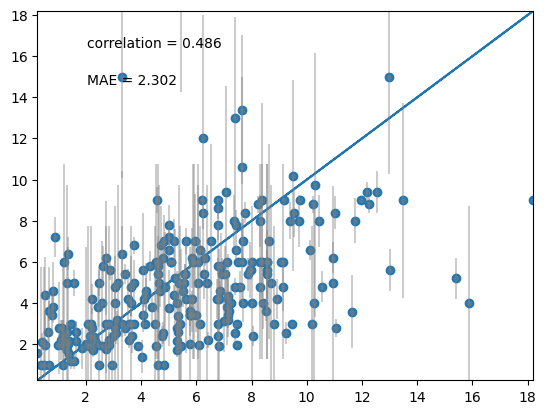

In [44]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

plt.plot(y,y)
lim=(min(y),max(y))
plt.xlim(lim)
plt.ylim(lim)
plt.scatter(y, [yhi.mean() for yhi in yhat])
plt.errorbar(y, 
            [yhi.mean() for yhi in yhat], 
            yerr=[yhi.std() for yhi in yhat],
            fmt='.', color='gray', alpha=0.4)
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 1*0.1*(max(y)-min(y)), f"correlation = {np.corrcoef(y, [yhi.mean() for yhi in yhat])[0,1]:.3f}")
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"MAE = {mean_absolute_error(y, [yhi.mean() for yhi in yhat]):.3f}")

### GPR

In [4]:
def run_C2_GPR_train(train_data, model="text-ada-001", N=50, k=16, pool=None):
    asktell = bolift.AskTellGPR(
        prefix="The following question should be answered with a number\n",
        prompt_template=PromptTemplate(
            input_variables=["x", "y", "y_name"],
            template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
        ),
        suffix="What is the {y_name} of {x}?@@@\nA:",
        x_formatter=lambda x: f"experimental procedure: {x}",
        y_name="C2 yield",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        pool=pool,
        n_components=k,
        # cache_path="GPR_ada_embed_cache.csv"
    )
    # Tell one example so the moduel build the prompt
    asktell.tell(train_data.iloc[0, 0], train_data.iloc[0, 1])
    exp_train_data = train_data.iloc[:N]

    examples = []
    for i in range(len(exp_train_data)):
        examples.append(dict(
            x=asktell.format_x(exp_train_data.iloc[i, 0]),
            y=asktell.format_y(exp_train_data.iloc[i, 1]),
            y_name=asktell._y_name,
            )
        )
    asktell._train(
            [asktell.prompt.format(
                x=ex["x"],
                y_name=asktell._y_name,
                )
             for ex in examples
            ], 
            [ex["y"] for ex in examples]
        )
    return asktell

def run_C2_GPR_ablation(train_data, test_data, model="text-curie-001", T=0.05, N=50, k=10,pool=None):
    asktell = run_C2_GPR_train(train_data, model="text-ada-001", N=N, k=k, pool=pool)

    exp_train_data = train_data.iloc[:N]
    x, y, yhat =  run_ablation_experiment(asktell, exp_train_data, test_data)

    data="C2"
    model_class="GPR"
    # asktell.save_cache("GPR_ada_embed_cache.csv")
    save_csv(out_csv_file, x, y, yhat, data, model, T, k, N, model_class, asktell.tokens_used)

    return y, yhat

In [9]:
T_list = [0.05]
k_list = [2]
N_list = [500]
models_list = ["text-ada-001"]
pool = bolift.Pool(train_data['prompt'].to_list(), formatter=lambda x: f"experimental procedure: {x}")
for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
  print(f"Running C2 GPT ablation with T={T}, k={k}, N={N}, model={model}", end=" ")
  pool.reset()
  y, yhat = run_C2_GPR_ablation(train_data[:N], test_data, model=model, T=T, N=N, k=k, pool=pool)
  print(" --> done")

Running C2 GPT ablation with T=0.05, k=2, N=500, model=text-ada-001 Cached embeddings not found. Creating new cache table.


/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:352: UserWarning: The number of connected components of the neighbors graph is 59 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/homebrew/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/homebrew/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/homebrew/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/homebrew/lib/python3.

 --> done


In [10]:
print(y)
print(yhat)

[5.85, 2.44, 7.64, 7.7, 1.2, 4.66, 6.26, 9.15, 5.34, 4.13, 5.63, 7.77, 8.31, 7.64, 13.01, 7.41, 5.3, 11.03, 4.05, 7.19, 3.41, 0.87, 2.23, 9.77, 4.59, 0.68, 2.01, 12.19, 9.72, 5.0, 0.64, 4.68, 4.19, 3.56, 2.49, 6.14, 3.32, 8.56, 8.04, 2.98, 11.07, 12.27, 2.23, 6.06, 1.36, 8.41, 5.78, 10.13, 9.07, 0.81, 7.71, 4.81, 4.54, 8.57, 4.09, 4.61, 5.79, 0.79, 3.06, 2.17, 1.14, 8.57, 5.63, 2.63, 2.6, 2.13, 7.0, 8.38, 11.64, 8.56, 4.63, 0.36, 3.63, 5.03, 11.98, 5.22, 7.43, 2.29, 6.31, 1.24, 0.25, 7.35, 15.89, 1.57, 15.4, 9.49, 1.48, 5.2, 2.84, 2.09, 8.52, 6.09, 3.57, 7.52, 7.16, 3.64, 1.63, 1.14, 5.0, 4.19, 6.76, 10.45, 7.15, 9.47, 2.72, 3.16, 2.26, 7.97, 9.14, 6.78, 3.74, 4.06, 1.66, 1.33, 3.75, 7.89, 10.96, 0.42, 3.89, 4.62, 1.18, 6.82, 5.87, 7.48, 6.54, 7.12, 5.84, 4.34, 8.32, 6.92, 2.73, 0.53, 4.63, 8.64, 8.25, 5.76, 6.08, 8.01, 9.19, 5.41, 5.86, 6.8, 5.32, 6.13, 6.78, 1.85, 6.28, 1.4, 5.6, 10.96, 3.32, 4.86, 0.81, 10.19, 2.74, 3.07, 12.99, 3.41, 5.95, 1.33, 8.32, 5.32, 5.07, 5.08, 6.8, 3.51, 7

Text(2.0460000000000003, 14.618, 'MAE = 2.291')

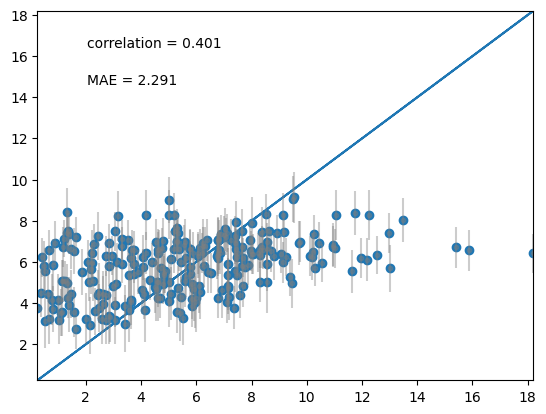

In [11]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

plt.plot(y,y)
lim=(min(y),max(y))
plt.xlim(lim)
plt.ylim(lim)
plt.scatter(y, [yhi.mean() for yhi in yhat])
plt.errorbar(y, 
            [yhi.mean() for yhi in yhat], 
            yerr=[yhi.std() for yhi in yhat],
            fmt='.', color='gray', alpha=0.4)
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 1*0.1*(max(y)-min(y)), f"correlation = {np.corrcoef(y, [yhi.mean() for yhi in yhat])[0,1]:.3f}")
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"MAE = {mean_absolute_error(y, [yhi.mean() for yhi in yhat]):.3f}")

### Ridge Kernel

In [43]:
def run_C2_ridge_train(train_data, model="text-ada-001", N=50, k=16, pool=None):
    asktell = bolift.AskTellRidgeKernelRegression(
        prefix="The following question should be answered with a number\n",
        prompt_template=PromptTemplate(
            input_variables=["x", "y", "y_name"],
            template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
        ),
        suffix="What is the {y_name} of {x}?@@@\nA:",
        x_formatter=lambda x: f"experimental procedure: {x}",
        y_name="C2 yield",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        alpha=0.5
    )
    # Tell one example so the module build the prompt
    asktell.tell(train_data.iloc[0, 0], train_data.iloc[0, 1], train=False)
    exp_train_data = train_data.iloc[:N]

    examples = []
    for i in range(len(exp_train_data)):
        examples.append(dict(
            x=asktell.format_x(exp_train_data.iloc[i, 0]),
            y=asktell.format_y(exp_train_data.iloc[i, 1]),
            y_name=asktell._y_name,
            )
        )
    asktell._train(
            [asktell.prompt.format(
                x=ex["x"],
                y_name=asktell._y_name,
                )
             for ex in examples
            ], 
            [ex["y"] for ex in examples]
        )
    return asktell

def run_C2_ridge_ablation(train_data, test_data, model="text-curie-001", T=0.05, N=50, k=10,pool=None):
    asktell = run_C2_ridge_train(train_data, model="text-ada-001", N=N, k=k, pool=pool)

    exp_train_data = train_data.iloc[:N]
    x, y, yhat =  run_ablation_experiment(asktell, exp_train_data, test_data)

    data="C2"
    model_class="KRR"
    # asktell.save_cache("GPR_ada_embed_cache.csv")
    save_csv(out_csv_file, x, y, yhat, data, model, T, k, N, model_class, asktell.tokens_used)

    return y, yhat

In [44]:
T_list = [0.05]
k_list = [0]
N_list = [100]
models_list = ["text-ada-001"]
pool = bolift.Pool(train_data['prompt'].to_list(), formatter=lambda x: f"experimental procedure: {x}")
for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
  print(f"Running C2 krr ablation with T={T}, k={k}, N={N}, model={model}", end=" ")
  pool.reset()
  y, yhat = run_C2_ridge_ablation(train_data[:N], test_data, model=model, T=T, N=N, k=k, pool=pool)
  print(" --> done")

Running C2 GPT ablation with T=0.05, k=0, N=100, model=text-ada-001 Cached embeddings not found. Creating new cache table.


/Users/maykcaldas/Documents/WhiteLab/BO-LIFT/bolift/asktellRidgeRegression.py:25: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std


 --> done


In [27]:
print(y)
print(yhat)

[5.85, 2.44, 7.64, 7.7, 1.2, 4.66, 6.26, 9.15, 5.34, 4.13, 5.63, 7.77, 8.31, 7.64, 13.01, 7.41, 5.3, 11.03, 4.05, 7.19, 3.41, 0.87, 2.23, 9.77, 4.59, 0.68, 2.01, 12.19, 9.72, 5.0, 0.64, 4.68, 4.19, 3.56, 2.49, 6.14, 3.32, 8.56, 8.04, 2.98, 11.07, 12.27, 2.23, 6.06, 1.36, 8.41, 5.78, 10.13, 9.07, 0.81, 7.71, 4.81, 4.54, 8.57, 4.09, 4.61, 5.79, 0.79, 3.06, 2.17, 1.14, 8.57, 5.63, 2.63, 2.6, 2.13, 7.0, 8.38, 11.64, 8.56, 4.63, 0.36, 3.63, 5.03, 11.98, 5.22, 7.43, 2.29, 6.31, 1.24, 0.25, 7.35, 15.89, 1.57, 15.4, 9.49, 1.48, 5.2, 2.84, 2.09, 8.52, 6.09, 3.57, 7.52, 7.16, 3.64, 1.63, 1.14, 5.0, 4.19, 6.76, 10.45, 7.15, 9.47, 2.72, 3.16, 2.26, 7.97, 9.14, 6.78, 3.74, 4.06, 1.66, 1.33, 3.75, 7.89, 10.96, 0.42, 3.89, 4.62, 1.18, 6.82, 5.87, 7.48, 6.54, 7.12, 5.84, 4.34, 8.32, 6.92, 2.73, 0.53, 4.63, 8.64, 8.25, 5.76, 6.08, 8.01, 9.19, 5.41, 5.86, 6.8, 5.32, 6.13, 6.78, 1.85, 6.28, 1.4, 5.6, 10.96, 3.32, 4.86, 0.81, 10.19, 2.74, 3.07, 12.99, 3.41, 5.95, 1.33, 8.32, 5.32, 5.07, 5.08, 6.8, 3.51, 7

Text(2.0460000000000003, 14.618, 'MAE = 1.648')

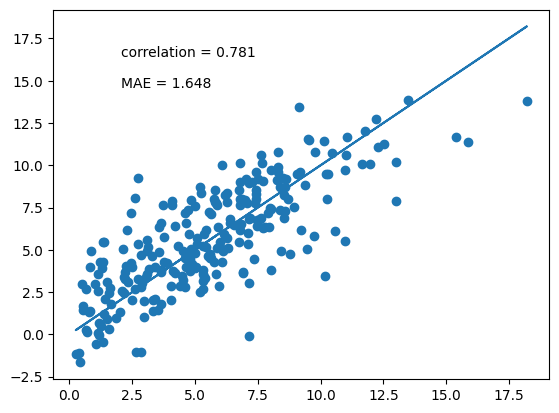

In [41]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

plt.plot(y,y)
lim=(min(y),max(y))
# plt.xlim(lim)
# plt.ylim(lim)
plt.scatter(y, [yhi.mean() for yhi in yhat])
# plt.errorbar(y, 
#             [yhi.mean() for yhi in yhat], 
#             yerr=[yhi.std() for yhi in yhat],
#             fmt='.', color='gray', alpha=0.4)
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 1*0.1*(max(y)-min(y)), f"correlation = {np.corrcoef(y, [yhi.mean() for yhi in yhat])[0,1]:.3f}")
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"MAE = {mean_absolute_error(y, [yhi.mean() for yhi in yhat]):.3f}")

### Finetune

In [50]:
def run_C2_finetune(train_data, model="text-ada-001", N=50):
    asktell = bolift.AskTellFinetuning(
        prefix="",
        prompt_template=PromptTemplate(
            input_variables=["x", "y", "y_name"],
            template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
        ),
        suffix="What is the {y_name} of {x}?@@@\nA:",
        x_formatter=lambda x: f"experimental procedure: {x}",
        y_name="C2 yield",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        n_epochs=8,
        learning_rate_multiplier=0.05,
    )
    # Tell one example so the moduel build the prompt
    asktell.tell(train_data.iloc[0, 0], train_data.iloc[0, 1])
    exp_train_data = train_data.iloc[:N]

    prompts=[]
    completions=[]
    for i in range(len(exp_train_data)):
        prompts.append(f"What is the yield strength of {exp_train_data.iloc[i, 0]}?@@@\\nA: ")
        completions.append(f"{float(exp_train_data.iloc[i, 1])}###")
    asktell.prepare_data(prompts, completions, f'./paper/out/data_C2_{N}.dat')
    asktell.fine_tune(prompts, completions, out_path='./paper/out', out_file=f'FT_C2_{N}')
    print(asktell.get_model_name())

def run_C2_FT_ablation(train_data, test_data, model="text-ada-001", T=0.7, N=10, k=0):
    with open(f'./paper/out/FT_C2_{N}.dat', 'r') as f:
        response = json.load(f)
    
    asktell = bolift.AskTellFinetuning(
        prefix="",
        prompt_template=PromptTemplate(
            input_variables=["x", "y", "y_name"],
            template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
        ),
        suffix="What is the {y_name} of {x}?@@@\nA:",
        y_name="C2 yield",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        id=response['id'],
        # selector_k=0,
        n_epochs=8,
        learning_rate_multiplier=0.02,
    )
    asktell.tell(train_data.iloc[0, 0], train_data.iloc[0, 1])
    exp_train_data = train_data.iloc[:1]
    x, y, yhat =  run_ablation_experiment(asktell, exp_train_data, test_data)

    data="C2"
    model_class="finetune"
    save_csv(out_csv_file, x, y, yhat, data, asktell.get_model_name(), T, k, N, model_class, asktell.tokens_used)

    return y, yhat

In [ ]:
N_list=[50, 1000]
for N in N_list: 
  print(f"Running C2 FT with N={N}")
  run_C2_finetune(train_data, model="text-ada-001", N=N)
  print(" --> done")

In [ ]:
T_list = [0.5, 0.7, 1.0]
k_list = [0]
N_list = [1000]
models_list = ["text-ada-001"]
for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
  print(f"Running C2 finetune ablation with T={T}, k={k}, N={N}, model={model}", end=" ")
  y, yhat = run_C2_FT_ablation(train_data, test_data, model="text-ada-001", T=T, N=N, k=k)
  print(" --> done")

### k-NN

In [18]:
def run_C2_knn_train(train_data, model="text-ada-001", N=50, k=16, pool=None):
    asktell = bolift.AskTellNearestNeighbor(
        prefix="The following question should be answered with a number\n",
        prompt_template=PromptTemplate(
            input_variables=["x", "y", "y_name"],
            template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
        ),
        suffix="What is the {y_name} of {x}?@@@\nA:",
        x_formatter=lambda x: f"experimental procedure: {x}",
        y_name="C2 yield",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        knn=5,
    )
    # Tell one example so the module build the prompt
    asktell.tell(train_data.iloc[0, 0], train_data.iloc[0, 1])
    exp_train_data = train_data.iloc[:N]

    examples = []
    for i in range(len(exp_train_data)):
        asktell.tell(exp_train_data.iloc[i, 0], exp_train_data.iloc[i, 1])
    return asktell

def run_C2_knn_ablation(train_data, test_data, model="text-curie-001", T=0.05, N=50, k=10,pool=None):
    asktell = run_C2_knn_train(train_data, model="text-ada-001", N=N, k=k, pool=pool)

    exp_train_data = train_data.iloc[:N]
    x, y, yhat =  run_ablation_experiment(asktell, exp_train_data, test_data)

    data="C2"
    model_class="KNN"
    # asktell.save_cache("GPR_ada_embed_cache.csv")
    save_csv(out_csv_file, x, y, yhat, data, model, T, k, N, model_class, asktell.tokens_used)

    return y, yhat

In [19]:
T_list = [0.05]
k_list = [5]
N_list = [1000]
models_list = ["text-ada-001"]
pool = bolift.Pool(train_data['prompt'].to_list(), formatter=lambda x: f"experimental procedure: {x}")
for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
  print(f"Running C2 knn ablation with T={T}, k={k}, N={N}, model={model}", end=" ")
  pool.reset()
  y, yhat = run_C2_knn_ablation(train_data[:N], test_data, model=model, T=T, N=N, k=k, pool=pool)
  print(" --> done") 

Running C2 knn ablation with T=0.05, k=5, N=1000, model=text-ada-001 

Using embedded DuckDB without persistence: data will be transient


 --> done


Text(2.0460000000000003, 14.618, 'MAE = 1.914')

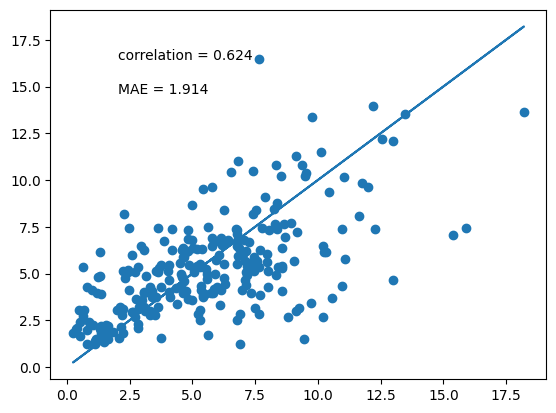

In [20]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

plt.plot(y,y)
lim=(min(y),max(y))
# plt.xlim(lim)
# plt.ylim(lim)
plt.scatter(y, [yhi.mean() for yhi in yhat])
# plt.errorbar(y, 
#             [yhi.mean() for yhi in yhat], 
#             yerr=[yhi.std() for yhi in yhat],
#             fmt='.', color='gray', alpha=0.4)
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 1*0.1*(max(y)-min(y)), f"correlation = {np.corrcoef(y, [yhi.mean() for yhi in yhat])[0,1]:.3f}")
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"MAE = {mean_absolute_error(y, [yhi.mean() for yhi in yhat]):.3f}")

## Iupac-solubility

In [13]:
import requests
data_path = "paper/data/esol_iupac.csv"
raw_data = pd.read_csv(data_path)

def query2IUPAC(text):
  try:
    '''This function queries the one given molecule name and returns a SMILES string from the record'''
    #query the PubChem database
    r = requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/' + text + '/property/IUPACName/JSON')
    data = r.json()
    smi = data["PropertyTable"]["Properties"][0]["IUPACName"]
    return smi
  except:
    return None

# raw_data["IUPAC"] = raw_data["SMILES"].map(lambda sml: query2IUPAC(sml))
raw_data = raw_data[["IUPAC", "measured log(solubility:mol/L)"]]
raw_data = raw_data.dropna()

In [14]:
np.random.seed(0)

N = raw_data.shape[0]
train = np.random.choice(raw_data.shape[0], int(N * 0.8), replace=False)
test = np.setdiff1d(np.arange(raw_data.shape[0]), train)
np.random.shuffle(test)

train_data = raw_data.iloc[train, :].reset_index(drop=True)
test_data = raw_data.iloc[test, :].reset_index(drop=True)
print(N, len(train_data), len(test_data))

882 705 177


### multi

In [11]:
def run_iupac_sol_multi_ablation(train_data, test_data, model="text-curie-001", T=0.05, N=50, k=10):
    asktell = bolift.AskTellFewShotMulti(
        x_formatter=lambda x: f"iupac name {x}",
        y_name="measured log solubility in mols per litre",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        selector_k=k,
        temperature=T
)
    exp_train_data = train_data[:N]
    x, y, yhat =  run_ablation_experiment(asktell, exp_train_data, test_data)

    data="iupac-sol"
    model_class="multi"
    save_csv(out_csv_file, x, y, yhat, data, model, T, k, N, model_class, asktell.tokens_used)

    return y, yhat

In [12]:
T_list = [1.0]
k_list = [5]
N_list = [1,5,10,25,50,100,250,500]
models_list = ["text-curie-001"]
for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
  print(f"Running iupac-solv multi ablation with T={T}, k={k}, N={N}, model={model}", end=" ")
  y, yhat = run_iupac_sol_multi_ablation(train_data, test_data, model=model, T=T, N=N, k=k)
  print(" --> done")

Running iupac-solv multi ablation with T=1.0, k=5, N=1, model=text-curie-001  --> done
Running iupac-solv multi ablation with T=1.0, k=5, N=5, model=text-curie-001  --> done
Running iupac-solv multi ablation with T=1.0, k=5, N=10, model=text-curie-001  --> done
Running iupac-solv multi ablation with T=1.0, k=5, N=25, model=text-curie-001  --> done
Running iupac-solv multi ablation with T=1.0, k=5, N=50, model=text-curie-001  --> done
Running iupac-solv multi ablation with T=1.0, k=5, N=100, model=text-curie-001  --> done
Running iupac-solv multi ablation with T=1.0, k=5, N=250, model=text-curie-001  --> done
Running iupac-solv multi ablation with T=1.0, k=5, N=500, model=text-curie-001  --> done


### topk

In [5]:
def run_iupac_sol_topk_ablation(train_data, test_data, model="text-curie-001", T=0.05, N=50, k=10):
    asktell = bolift.AskTellFewShotTopk(
        x_formatter=lambda x: f"iupac name {x}",
        y_name="measured log solubility in mols per litre",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        selector_k=k,
        temperature=T
    )
    x, y, yhat =  run_ablation_experiment(asktell, train_data, test_data)

    data="iupac-sol"
    model_class="topk"
    save_csv(out_csv_file, x, y, yhat, data, model, T, k, N, model_class, asktell.tokens_used)

    return y, yhat

In [15]:
T_list = [0.7]
k_list = [5]
N_list = [700]
models_list = ["text-davinci-003"]
for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
  print(f"Running iupac-sol topk ablation with T={T}, k={k}, N={N}, model={model}", end=" ")
  y, yhat = run_iupac_sol_topk_ablation(train_data, test_data, model=model, T=T, N=N, k=k)
  print(" --> done")

Running iupac-sol topk ablation with T=0.7, k=5, N=700, model=text-davinci-003  --> done


### GPR

In [6]:
def run_iupac_sol_GPR_train(train_data, model="text-ada-001", N=50, k=16, pool=None):
    asktell = bolift.AskTellGPR(
        prefix="The following question should be answered with a number\n",
        prompt_template=PromptTemplate(
            input_variables=["x", "y", "y_name"],
            template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
        ),
        suffix="What is the {y_name} of {x}?@@@\nA:",
        x_formatter=lambda x: f"iupac name {x}",
        y_name="measured log solubility in mols per litre",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        pool=pool,
        n_components=k,
        # cache_path="GPR_ada_embed_cache.csv"
    )
    # Tell one example so the moduel build the prompt
    asktell.tell(train_data.iloc[0, 0], train_data.iloc[0, 1])
    exp_train_data = train_data.iloc[:N]

    examples = []
    for i in range(len(exp_train_data)):
        examples.append(dict(
            x=asktell.format_x(exp_train_data.iloc[i, 0]),
            y=asktell.format_y(exp_train_data.iloc[i, 1]),
            y_name=asktell._y_name,
            )
        )
    asktell._train(
            [asktell.prompt.format(
                x=ex["x"],
                y_name=asktell._y_name,
                )
             for ex in examples
            ], 
            [ex["y"] for ex in examples]
        )
    return asktell

def run_iupac_sol_GPR_ablation(train_data, test_data, model="text-curie-001", T=0.05, N=50, k=16, pool=None):
    asktell = run_iupac_sol_GPR_train(train_data, model="text-ada-001", N=N, k=k, pool=pool)

    exp_train_data = train_data.iloc[:N]
    x, y, yhat =  run_ablation_experiment(asktell, exp_train_data, test_data)

    data="iupac-sol"
    model_class="GPR"
    # asktell.save_cache("GPR_ada_embed_cache.csv")
    save_csv(out_csv_file, x, y, yhat, data, model, T, k, N, model_class, asktell.tokens_used)

    return y, yhat

In [7]:
T_list = [0.05]
k_list = [2,4,8,16,32,64,128,256]
N_list = [1,5,10,25,50,100,250,500,700]
models_list = ["text-ada-001"]
pool = bolift.Pool(train_data['IUPAC'].to_list(), formatter=lambda x: f"iupac name {x}")
for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
  print(f"Running iupac-sol GPR ablation with T={T}, k={k}, N={N}, model={model}", end=" ")
  pool.reset()
  y, yhat = run_iupac_sol_GPR_ablation(train_data[:N], test_data, model=model, T=T, N=N, k=k, pool=pool)
  print(" --> done")

Running iupac-sol GPR ablation with T=0.05, k=0, N=1, model=text-ada-001 Cached embeddings not found. Creating new cache table.


C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\optim\utils\common.py:31: UserWarning: Keyword arguments ['maxiter', 'disp'] will be ignored because they are not allowed parameters for function Adam. Allowed parameters are ['params', 'lr', '

 --> done
Running iupac-sol GPR ablation with T=0.05, k=0, N=5, model=text-ada-001 Cached embeddings not found. Creating new cache table.


C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\optim\utils\common.py:31: UserWarning: Keyword arguments ['maxiter', 'disp'] will be ignored because they are not allowed parameters for function Adam. Allowed parameters are ['params', 'lr', '

 --> done
Running iupac-sol GPR ablation with T=0.05, k=0, N=10, model=text-ada-001 Cached embeddings not found. Creating new cache table.


C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\optim\utils\common.py:31: UserWarning: Keyword arguments ['maxiter', 'disp'] will be ignored because they are not allowed parameters for function Adam. Allowed parameters are ['params', 'lr', '

 --> done
Running iupac-sol GPR ablation with T=0.05, k=0, N=25, model=text-ada-001 Cached embeddings not found. Creating new cache table.


C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\optim\utils\common.py:31: UserWarning: Keyword arguments ['maxiter', 'disp'] will be ignored because they are not allowed parameters for function Adam. Allowed parameters are ['params', 'lr', '

 --> done
Running iupac-sol GPR ablation with T=0.05, k=0, N=50, model=text-ada-001 Cached embeddings not found. Creating new cache table.


C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\optim\utils\common.py:31: UserWarning: Keyword arguments ['maxiter', 'disp'] will be ignored because they are not allowed parameters for function Adam. Allowed parameters are ['params', 'lr', '

 --> done
Running iupac-sol GPR ablation with T=0.05, k=0, N=100, model=text-ada-001 Cached embeddings not found. Creating new cache table.


C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\optim\utils\common.py:31: UserWarning: Keyword arguments ['maxiter', 'disp'] will be ignored because they are not allowed parameters for function Adam. Allowed parameters are ['params', 'lr', '

 --> done
Running iupac-sol GPR ablation with T=0.05, k=0, N=250, model=text-ada-001 Cached embeddings not found. Creating new cache table.


C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\optim\utils\common.py:31: UserWarning: Keyword arguments ['maxiter', 'disp'] will be ignored because they are not allowed parameters for function Adam. Allowed parameters are ['params', 'lr', '

 --> done
Running iupac-sol GPR ablation with T=0.05, k=0, N=500, model=text-ada-001 Cached embeddings not found. Creating new cache table.


C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\optim\utils\common.py:31: UserWarning: Keyword arguments ['maxiter', 'disp'] will be ignored because they are not allowed parameters for function Adam. Allowed parameters are ['params', 'lr', '

 --> done
Running iupac-sol GPR ablation with T=0.05, k=0, N=700, model=text-ada-001 Cached embeddings not found. Creating new cache table.


C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\maykc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\optim\utils\common.py:31: UserWarning: Keyword arguments ['maxiter', 'disp'] will be ignored because they are not allowed parameters for function Adam. Allowed parameters are ['params', 'lr', '

 --> done


[GaussDist(-2.494743926373925, 1.1539771677023916), GaussDist(-1.2413082513341296, 1.540688984672134), GaussDist(-2.6125169819300402, 1.4801460503893402), GaussDist(-3.703540459525434, 1.1549212333101504), GaussDist(-1.053794399069654, 0.958830206680167), GaussDist(-1.4211643963683462, 1.3486117769422972), GaussDist(-2.2715148214344048, 1.1782444108756467), GaussDist(-2.0279625061754607, 1.7220870882075672), GaussDist(-1.7351726620981622, 1.480314864774257), GaussDist(-2.5514191364385783, 1.7395957887537428), GaussDist(-2.5980133712247744, 1.241531349829522), GaussDist(-2.8841390016549573, 1.5456790075415667), GaussDist(-3.6619561567793664, 1.7111980891309806), GaussDist(-2.9549746117354716, 1.5793942488878003), GaussDist(-0.7575132853570998, 1.3114427294037698), GaussDist(-1.9443059299718803, 0.9507127839341568), GaussDist(-2.372433101066579, 1.0964855865606034), GaussDist(-4.118118114698591, 1.047341666205534), GaussDist(-2.3215832118484023, 1.1696778390377003), GaussDist(-3.95835600

Text(-8.241800000000001, -0.6104, 'MAE = 1.146')

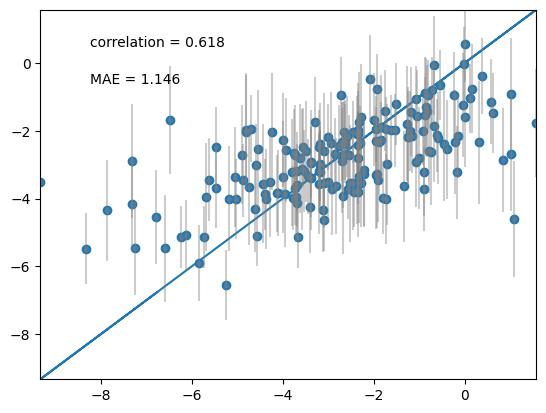

In [41]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
print(yhat)
plt.plot(y,y)
lim=(min(y),max(y))
plt.xlim(lim)
plt.ylim(lim)
plt.scatter(y, [yhi.mean() for yhi in yhat])
plt.errorbar(y, 
            [yhi.mean() for yhi in yhat], 
            yerr=[yhi.std() for yhi in yhat],
            fmt='.', color='gray', alpha=0.4)
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 1*0.1*(max(y)-min(y)), f"correlation = {np.corrcoef(y, [yhi.mean() for yhi in yhat])[0,1]:.3f}")
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"MAE = {mean_absolute_error(y, [yhi.mean() for yhi in yhat]):.3f}")

### Finetune

In [7]:
def run_iupac_sol_finetune(train_data, model="text-ada-001", N=50):
    asktell = bolift.AskTellFinetuning(
        prefix="",
        prompt_template=PromptTemplate(
            input_variables=["x", "y", "y_name"],
            template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
        ),
        suffix="What is the {y_name} of {x}?@@@\nA:",
        # x_formatter=lambda x: f"iupac name {x}",
        y_name="measured log solubility in mols per litre",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        n_epochs=8,
        learning_rate_multiplier=0.02,
    )
    asktell.tell(train_data.iloc[0, 0], train_data.iloc[0, 1])
    exp_train_data = train_data.iloc[:N]

    prompts=[]
    completions=[]
    for i in range(len(train_data[:N])):
        prompts.append(f"What is the measured log solubility in mols per litre of {exp_train_data.iloc[i, 0]}?@@@\\nA: ")
        completions.append(f"{float(exp_train_data.iloc[i, 1])}###")
        asktell.prepare_data(prompts, completions, f'./paper/out/data_solv_{N}.dat')
    asktell.fine_tune(prompts, completions, out_path='./paper/out', out_file=f'FT_solv_{N}')
    print(asktell.get_model_name())

def run_iupac_sol_FT_ablation(train_data, test_data, model="text-ada-001", T=0.05, N=50, k=0):
    with open(f'./paper/out/FT_solv_{N}.dat', 'r') as f:
        response = json.load(f)
    
    asktell = bolift.AskTellFinetuning(
        prefix="",
        prompt_template=PromptTemplate(
            input_variables=["x", "y", "y_name"],
            template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
        ),
        suffix="What is the {y_name} of {x}?@@@\nA:",
        # x_formatter=lambda x: f"iupac name {x}",
        y_name="measured log solubility in mols per litre",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        id=response['id'],
        selector_k=0,
        n_epochs=8,
        learning_rate_multiplier=0.02,
    )
    asktell.tell(train_data.iloc[0, 0], train_data.iloc[0, 1])
    exp_train_data = train_data.iloc[:N]
    x, y, yhat =  run_ablation_experiment(asktell, exp_train_data, test_data)

    data="iupac-sol"
    model_class="finetune"
    save_csv(out_csv_file, x, y, yhat, data, asktell.get_model_name(), T, k, N, model_class, asktell.tokens_used)

    return y, yhat

In [ ]:
N_list=[50,100,250,500,700]
for N in N_list:
  print(f"Running iupac-sol FT with N={N}")
  run_iupac_sol_finetune(train_data, model="text-ada-001", N=N)
  print(" --> done")

In [ ]:
T_list = [0.7]
k_list = [0]
N_list=[50,100,250,500,700]
models_list = ["text-ada-001"]
for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
  print(f"Running iupac-sol finetune ablation with T={T}, k={k}, N={N}, model={model}", end=" ")
  y, yhat = run_iupac_sol_FT_ablation(train_data, test_data, model="text-ada-001", T=T, N=N, k=k)
  print(" --> done")


### Ridge Regression

In [31]:
def run_sol_ridge_train(train_data, model="text-ada-001", N=50, k=16, pool=None):
    asktell = bolift.AskTellRidgeKernelRegression(
        prefix="The following question should be answered with a number\n",
        prompt_template=PromptTemplate(
            input_variables=["x", "y", "y_name"],
            template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
        ),
        suffix="What is the {y_name} of {x}?@@@\nA:",
        x_formatter=lambda x: f"iupac name {x}",
        y_name="measured log solubility in mols per litre",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        alpha=0.5
    )
    # Tell one example so the module build the prompt
    asktell.tell(train_data.iloc[0, 0], train_data.iloc[0, 1], train=False)
    exp_train_data = train_data.iloc[:N]

    examples = []
    for i in range(len(exp_train_data)):
        examples.append(dict(
            x=asktell.format_x(exp_train_data.iloc[i, 0]),
            y=asktell.format_y(exp_train_data.iloc[i, 1]),
            y_name=asktell._y_name,
            )
        )
    asktell._train(
            [asktell.prompt.format(
                x=ex["x"],
                y_name=asktell._y_name,
                )
             for ex in examples
            ], 
            [ex["y"] for ex in examples]
        )
    return asktell

def run_sol_ridge_ablation(train_data, test_data, model="text-curie-001", T=0.05, N=50, k=10,pool=None):
    asktell = run_sol_ridge_train(train_data, model="text-ada-001", N=N, k=k, pool=pool)

    exp_train_data = train_data.iloc[:N]
    x, y, yhat =  run_ablation_experiment(asktell, exp_train_data, test_data)

    data="iupac-sol"
    model_class="KRR"
    # asktell.save_cache("GPR_ada_embed_cache.csv")
    save_csv(out_csv_file, x, y, yhat, data, model, T, k, N, model_class, asktell.tokens_used)

    return y, yhat

In [33]:
T_list = [0.05]
k_list = [0]
N_list = [1,5,10,25,50,100,250,500,700]
models_list = ["text-ada-001"]
pool = bolift.Pool(train_data['IUPAC'].to_list(), formatter=lambda x: f"iupac name {x}")
for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
  print(f"Running sol GPT ablation with T={T}, k={k}, N={N}, model={model}", end=" ")
  pool.reset()
  y, yhat = run_sol_ridge_ablation(train_data[:N], test_data, model=model, T=T, N=N, k=k, pool=pool)
  print(" --> done")

Running sol GPT ablation with T=0.05, k=0, N=1, model=text-ada-001 Cached embeddings not found. Creating new cache table.


/Users/maykcaldas/Documents/WhiteLab/BO-LIFT/bolift/asktellRidgeRegression.py:25: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/Users/maykcaldas/Documents/WhiteLab/BO-LIFT/bolift/asktellRidgeRegression.py:25: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/Users/maykcaldas/Documents/WhiteLab/BO-LIFT/bolift/asktellRidgeRegression.py:25: RuntimeWarning: divide by zero encountered in divide
  return (X - mean) / std
/Users/maykcaldas/Documents/WhiteLab/BO-LIFT/bolift/asktellRidgeRegression.py:25: RuntimeWarning: divide by zero encountered in divide
  return (X - mean) / std
/Users/maykcaldas/Documents/WhiteLab/BO-LIFT/bolift/asktellRidgeRegression.py:25: RuntimeWarning: divide by zero encountered in divide
  return (X - mean) / std
/Users/maykcaldas/Documents/WhiteLab/BO-LIFT/bolift/asktellRidgeRegression.py:25: RuntimeWarning: divide by zero encountered in divide
  return (X - mean) / std
/Users/maykcaldas/Documents/WhiteLab

 --> done
Running sol GPT ablation with T=0.05, k=0, N=5, model=text-ada-001 Cached embeddings not found. Creating new cache table.


/Users/maykcaldas/Documents/WhiteLab/BO-LIFT/bolift/asktellRidgeRegression.py:25: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std


 --> done
Running sol GPT ablation with T=0.05, k=0, N=10, model=text-ada-001 Cached embeddings not found. Creating new cache table.


/Users/maykcaldas/Documents/WhiteLab/BO-LIFT/bolift/asktellRidgeRegression.py:25: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std


 --> done
Running sol GPT ablation with T=0.05, k=0, N=25, model=text-ada-001 Cached embeddings not found. Creating new cache table.


/Users/maykcaldas/Documents/WhiteLab/BO-LIFT/bolift/asktellRidgeRegression.py:25: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std


 --> done
Running sol GPT ablation with T=0.05, k=0, N=50, model=text-ada-001 Cached embeddings not found. Creating new cache table.


/Users/maykcaldas/Documents/WhiteLab/BO-LIFT/bolift/asktellRidgeRegression.py:25: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std


 --> done
Running sol GPT ablation with T=0.05, k=0, N=100, model=text-ada-001 Cached embeddings not found. Creating new cache table.


/Users/maykcaldas/Documents/WhiteLab/BO-LIFT/bolift/asktellRidgeRegression.py:25: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std


 --> done
Running sol GPT ablation with T=0.05, k=0, N=250, model=text-ada-001 Cached embeddings not found. Creating new cache table.


/Users/maykcaldas/Documents/WhiteLab/BO-LIFT/bolift/asktellRidgeRegression.py:25: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std


 --> done
Running sol GPT ablation with T=0.05, k=0, N=500, model=text-ada-001 Cached embeddings not found. Creating new cache table.


/Users/maykcaldas/Documents/WhiteLab/BO-LIFT/bolift/asktellRidgeRegression.py:25: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std


 --> done
Running sol GPT ablation with T=0.05, k=0, N=700, model=text-ada-001 Cached embeddings not found. Creating new cache table.


/Users/maykcaldas/Documents/WhiteLab/BO-LIFT/bolift/asktellRidgeRegression.py:25: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std


 --> done


Text(-8.241800000000001, -0.6104, 'MAE = 0.914')

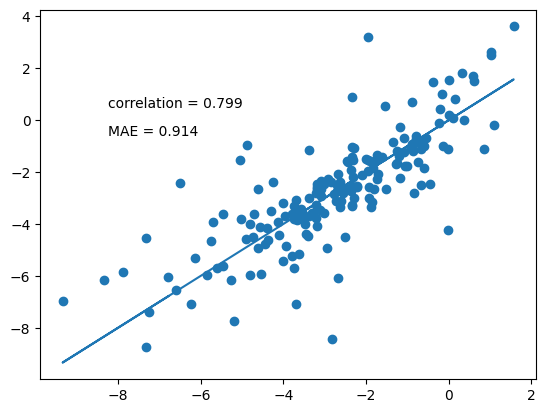

In [34]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

plt.plot(y,y)
lim=(min(y),max(y))
# plt.xlim(lim)
# plt.ylim(lim)
plt.scatter(y, [yhi.mean() for yhi in yhat])
# plt.errorbar(y, 
#             [yhi.mean() for yhi in yhat], 
#             yerr=[yhi.std() for yhi in yhat],
#             fmt='.', color='gray', alpha=0.4)
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 1*0.1*(max(y)-min(y)), f"correlation = {np.corrcoef(y, [yhi.mean() for yhi in yhat])[0,1]:.3f}")
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"MAE = {mean_absolute_error(y, [yhi.mean() for yhi in yhat]):.3f}")

### k-NN

In [16]:
def run_sol_knn_train(train_data, model="text-ada-001", N=50, k=16, pool=None):
    asktell = bolift.AskTellNearestNeighbor(
        prefix="The following question should be answered with a number\n",
        prompt_template=PromptTemplate(
            input_variables=["x", "y", "y_name"],
            template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
        ),
        suffix="What is the {y_name} of {x}?@@@\nA:",
        x_formatter=lambda x: f"iupac name {x}",
        y_name="measured log solubility in mols per litre",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        knn=1,
    )
    # Tell one example so the module build the prompt
    asktell.tell(train_data.iloc[0, 0], train_data.iloc[0, 1])
    exp_train_data = train_data.iloc[:N]

    examples = []
    for i in range(len(exp_train_data)):
        asktell.tell(exp_train_data.iloc[i, 0], exp_train_data.iloc[i, 1])
    return asktell

def run_sol_knn_ablation(train_data, test_data, model="text-curie-001", T=0.05, N=50, k=10,pool=None):
    asktell = run_sol_knn_train(train_data, model="text-ada-001", N=N, k=k, pool=pool)

    exp_train_data = train_data.iloc[:N]
    x, y, yhat =  run_ablation_experiment(asktell, exp_train_data, test_data)

    data="iupac-sol"
    model_class="KNN"
    # asktell.save_cache("GPR_ada_embed_cache.csv")
    save_csv(out_csv_file, x, y, yhat, data, model, T, k, N, model_class, asktell.tokens_used)

    return y, yhat

In [17]:
T_list = [0.05]
k_list = [0]
N_list = [5,10,25,50,100,250,500,700]
models_list = ["text-ada-001"]
pool = bolift.Pool(train_data['IUPAC'].to_list(), formatter=lambda x: f"iupac name {x}")
for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
  print(f"Running iupac-sol knn ablation with T={T}, k={k}, N={N}, model={model}", end=" ")
  pool.reset()
  y, yhat = run_sol_knn_ablation(train_data[:N], test_data, model=model, T=T, N=N, k=k, pool=pool)
  print(" --> done")

Using embedded DuckDB without persistence: data will be transient


Running iupac-sol knn ablation with T=0.05, k=0, N=5, model=text-ada-001 

Using embedded DuckDB without persistence: data will be transient


 --> done
Running iupac-sol knn ablation with T=0.05, k=0, N=10, model=text-ada-001 

Using embedded DuckDB without persistence: data will be transient


 --> done
Running iupac-sol knn ablation with T=0.05, k=0, N=25, model=text-ada-001 

Using embedded DuckDB without persistence: data will be transient


 --> done
Running iupac-sol knn ablation with T=0.05, k=0, N=50, model=text-ada-001 

Using embedded DuckDB without persistence: data will be transient


 --> done
Running iupac-sol knn ablation with T=0.05, k=0, N=100, model=text-ada-001 

Using embedded DuckDB without persistence: data will be transient


 --> done
Running iupac-sol knn ablation with T=0.05, k=0, N=250, model=text-ada-001 

Using embedded DuckDB without persistence: data will be transient


 --> done
Running iupac-sol knn ablation with T=0.05, k=0, N=500, model=text-ada-001 

Using embedded DuckDB without persistence: data will be transient


 --> done
Running iupac-sol knn ablation with T=0.05, k=0, N=1000, model=text-ada-001  --> done


Text(-8.241800000000001, -0.6104, 'MAE = 1.730')

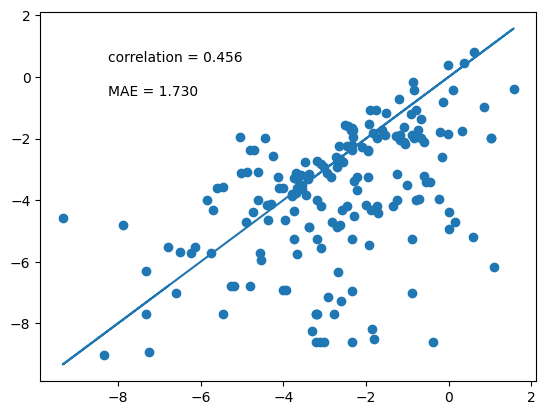

In [18]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

plt.plot(y,y)
lim=(min(y),max(y))
# plt.xlim(lim)
# plt.ylim(lim)
plt.scatter(y, [yhi.mean() for yhi in yhat])
# plt.errorbar(y, 
#             [yhi.mean() for yhi in yhat], 
#             yerr=[yhi.std() for yhi in yhat],
#             fmt='.', color='gray', alpha=0.4)
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 1*0.1*(max(y)-min(y)), f"correlation = {np.corrcoef(y, [yhi.mean() for yhi in yhat])[0,1]:.3f}")
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"MAE = {mean_absolute_error(y, [yhi.mean() for yhi in yhat]):.3f}")

## Tungsten

In [35]:
np.random.seed(8)

data_path = "paper/data/Tungsten carbide data.csv"
raw_data = pd.read_csv(data_path)

N = raw_data.shape[0]
train = np.random.choice(raw_data.shape[0], int(N * 0.8), replace=False)
test = np.setdiff1d(np.arange(raw_data.shape[0]), train)
np.random.shuffle(test)

train_data = raw_data.iloc[train, :].reset_index(drop=True)
test_data = raw_data.iloc[test, :].reset_index(drop=True)
print(N, len(train_data), len(test_data))

18 14 4


In [36]:
print(train_data.iloc[0,1])

4.63


In [39]:
asktell = bolift.AskTellFewShotTopk(
  prefix="This model was created to predict CO yield from a given experimental procedure. It is a difficult task and the answer should be numeric.",
  prompt_template=PromptTemplate(
      input_variables=["x", "y", "y_name"],
      template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
  ),
  suffix="What is the {y_name} of {x}?@@@\nA:",
  x_formatter=lambda x: f" the experimental procedure {x}",
  y_name="CO yield",
  y_formatter=lambda y: f"{y:.2f}%.",
  model="text-curie-001",
  selector_k=5,
  temperature=0.05
)

asktell.tell(train_data.iloc[0, 0], float(train_data.iloc[0, 1]))
for i in range(len(train_data)):
    asktell.tell(train_data.iloc[i, 0], float(train_data.iloc[i, 1]))
for i in range(len(test_data)):
    yhat = asktell.predict(test_data.iloc[i, 0]) 
    y = float(test_data.iloc[i, 1])
    print(yhat, y, y-yhat.mean())


GaussDist(2.85, 4.407320375113306) 16.35 13.500000000000002
GaussDist(3.03, 4.407320375113306) 4.12 1.0900000000000003
GaussDist(18.979999999999997, 4.407320375113306) 3.36 -15.619999999999997
GaussDist(2.8499999999999996, 4.407320375113306) 1.73 -1.1199999999999997


## Steel alloy

In [ ]:
np.random.seed(8)

data_path = "paper/data/yield_strength.csv"
raw_data = pd.read_csv(data_path)

N = raw_data.shape[0]
train = np.random.choice(raw_data.shape[0], int(N * 0.8), replace=False)
test = np.setdiff1d(np.arange(raw_data.shape[0]), train)
np.random.shuffle(test)

train_data = raw_data.iloc[train, :].reset_index(drop=True)
test_data = raw_data.iloc[test, :].reset_index(drop=True)
print(N, len(train_data), len(test_data))

312 249 63


### multi

In [ ]:
def run_alloy_multi_ablation(train_data, test_data, model="text-curie-001", T=0.05, N=50, k=10):
    asktell = bolift.AskTellFewShotMulti(
        x_formatter=lambda x: f"alloy composition of {x}",
        y_name="yield strength",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        selector_k=k,
        temperature=T
    )
    exp_train_data = train_data[:N]
    x, y, yhat =  run_ablation_experiment(asktell, exp_train_data, test_data)

    data="alloy"
    model_class="multi"
    save_csv(out_csv_file, x, y, yhat, data, model, T, k, N, model_class, asktell.tokens_used)

    return y, yhat


In [ ]:

T_list = [0.05]
k_list = [1,2,3,4]
N_list = [249]
for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
  print(f"Running alloy multi ablation with T={T}, k={k}, N={N}, model={model}", end=" ")
  y, yhat = run_alloy_multi_ablation(train_data, test_data, model=model, T=T, N=N, k=k)
  print(" --> done")

Running alloy multi ablation with T=0.05, k=1, N=249, model=text-curie-001  --> done
Running alloy multi ablation with T=0.05, k=2, N=249, model=text-curie-001  --> done
Running alloy multi ablation with T=0.05, k=3, N=249, model=text-curie-001  --> done
Running alloy multi ablation with T=0.05, k=4, N=249, model=text-curie-001  --> done


### topk

In [ ]:
def run_alloy_topk_ablation(train_data, test_data, model="text-curie-001", T=0.05, N=50, k=10):
    from openai import PromptTemplate
    
    asktell = bolift.AskTellFewShotTopk(
        x_formatter=lambda x: f"alloy composition of {x}",
        y_name="yield strength",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        selector_k=k,
        temperature=T
    )
    exp_train_data = train_data[:N]
    x, y, yhat =  run_ablation_experiment(asktell, exp_train_data, test_data)
    data="alloy"
    model_class="topk"
    save_csv(out_csv_file, x, y, yhat, data, model, T, k, N, model_class, asktell.tokens_used)

    return y, yhat


In [ ]:
T_list = [0.05]
k_list = [5]
N_list = [50] #[3,4,5,10,25,50,100,200]
for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
  print(f"Running alloy topk ablation with T={T}, k={k}, N={N}, model={model}", end=" ")
  y, yhat = run_alloy_topk_ablation(train_data, test_data, model=model, T=T, N=N, k=k)
  print(" --> done")

### Finetune

In [ ]:
def run_alloy_finetune(train_data, model="text-ada-001", N=50):
    asktell = bolift.AskTellFinetuning(
        prefix="",
        prompt_template=PromptTemplate(
            input_variables=["x", "y", "y_name"],
            template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
        ),
        suffix="What is the {y_name} of {x}?@@@\nA:",
        # x_formatter=lambda x: f"alloy composition: {x}",
        y_name="yield strength",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        n_epochs=8,
        learning_rate_multiplier=0.02,
    )
    # Tell one example so the moduel build the prompt
    asktell.tell(train_data.iloc[0, 0], train_data.iloc[0, 1])
    exp_train_data = train_data.iloc[:N]

    prompts=[]
    completions=[]
    for i in range(len(exp_train_data)):
        prompts.append(f"What is the yield strength of {exp_train_data.iloc[i, 0]}?@@@\\nA: ")
        completions.append(f"{float(exp_train_data.iloc[i, 1])}###")
    asktell.prepare_data(prompts, completions, f'./paper/out/data_alloy_{N}.dat')
    asktell.fine_tune(prompts, completions, out_path='./paper/out', out_file=f'FT_alloy_{N}')
    print(asktell.get_model_name())

def run_alloy_FT_ablation(train_data, test_data, model="text-ada-001", T=0.05, N=50, k=0):
    with open(f'./paper/out/FT_alloy_{N}.dat', 'r') as f:
        response = json.load(f)
    
    asktell = bolift.AskTellFinetuning(
        prefix="",
        prompt_template=PromptTemplate(
            input_variables=["x", "y", "y_name"],
            template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
        ),
        suffix="What is the {y_name} of {x}?@@@\nA:",
        # x_formatter=lambda x: f"alloy composition: {x}",
        y_name="yield strength",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        id=response['id'],
        selector_k=0,
        n_epochs=8,
        learning_rate_multiplier=0.02,
    )
    asktell.tell(train_data.iloc[0, 0], train_data.iloc[0, 1])
    exp_train_data = train_data.iloc[:N]
    x, y, yhat =  run_ablation_experiment(asktell, exp_train_data, test_data)

    data="alloy"
    model_class="finetune"
    save_csv(out_csv_file, x, y, yhat, data, asktell.get_model_name(), T, k, N, model_class, asktell.tokens_used)

    return y, yhat

In [ ]:
N_list=[249]
for N in N_list:
  print(f"Running alloy FT with N={N}")
  run_alloy_finetune(train_data, model="text-ada-001", N=N)
  print(" --> done")

Running alloy FT with N=249
text-ada-001
running.   Fine-tune succeeded                                                                

ada:ft-white-research-laboratory-2023-02-27-21-12-15
 --> done


In [ ]:
T_list = [0.05]
k_list = [0]
N_list = [249]
models_list = ["text-ada-001"]
for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
  print(f"Running alloy finetune ablation with T={T}, k={k}, N={N}, model={model}", end=" ")
  y, yhat = run_alloy_FT_ablation(train_data, test_data, model="text-ada-001", T=T, N=N, k=k)
  print(" --> done")


Running alloy finetune ablation with T=0.05, k=0, N=249, model=text-ada-001 text-ada-001
ada:ft-white-research-laboratory-2023-02-27-21-12-15
 --> done
